## Flight finder from Ryanair website

In [1]:
######## IMPORT ########
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support.ui import Select
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
import datetime
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
from matplotlib.figure import Figure
from matplotlib.backends.backend_agg import FigureCanvas
import panel as pn
import warnings
warnings.filterwarnings("ignore")

## Main functions

In [2]:
######## FUNCTIONS ########

def myClick(ptime,by,desc):
    wait = WebDriverWait(driver, ptime)
    by = by.upper()
    if by == 'XPATH':
        return wait.until(EC.presence_of_element_located((By.XPATH, desc))).click()
    elif by == 'ID':
        return wait.until(EC.presence_of_element_located((By.ID, desc))).click()
    elif by == 'CLASS':
        return wait.until(EC.presence_of_element_located((By.CLASS_NAME, desc))).click()    
    elif by == 'LINK_TEXT':
        return wait.until(EC.presence_of_element_located((By.LINK_TEXT, desc))).click()

def text_fill(ptime,by,text_fill,desc):
    by = by.upper()
    wait = WebDriverWait(driver, ptime)    
    if by == 'XPATH':
        form = wait.until(EC.presence_of_element_located((By.XPATH, desc)))
#         form = driver.find_element_by_xpath(desc)
    form.send_keys(Keys.CONTROL + "a")
    return form.send_keys(text_fill)

def date_selec(input_date,elems,attlook,active_flag,attget):
    dates_act = []
    for elem in elems:
        if elem.get_attribute(attlook) == active_flag:
            dates_act.append(elem.get_attribute(attget))

    dates_act2 = []
    for i, date in enumerate(dates_act):
        dates_act2.append(datetime.datetime.strptime(date,'%Y-%m-%d'))

    return '"'+str(min(dates_act2, key=lambda sub: abs(sub - datetime.datetime.strptime(input_date.strip('""'),'%Y-%m-%d')))).strip(" 00:00:00")+'"'

def get_destinations_list(by,desc):
    by = by.upper()
    if by == "XPATH":
        destinations = driver.find_element_by_xpath(desc)
    dest_list = destinations.text.split("\n")
    try:
        dest_list.remove("NEW")
    except:
        pass
    try:
        dest_list.remove("Any destination")
    except:
        pass
    try:
        dest_list = [x for x in dest_list if "All Airports" not in x]
    except:
        pass
    try:
        dest_list = [x for x in dest_list if "1 stop" not in x]
    except:
        pass
    for i,e in enumerate(dest_list):
        if " (Operated by" in e:
#             dest_list[i] = e[:e.find(" (Operated by")] # strip of operado por
           dest_list.remove(e) 
  
    return dest_list

def date_price(input_date,by,desc):
    by = by.upper()
    if by == "XPATH":    
        elem = driver.find_elements_by_xpath(desc)
    else:
        print("Specify element format")
    
    list_dates = []
    price = {}
    d = {}
    for i,e in enumerate(elem):
        list_dates.append(e.text.replace("\n","").replace(",","."))
    
    list_dates = [x for x in list_dates if x] # Elimino elementos vacios para tener solo 5 indices
    
    for i,e in enumerate(list_dates):
        if list_dates[i].find("€") != -1:
            price[i] = float(list_dates[i][list_dates[i].find("€")+1:])
            d[i] = datetime.datetime.strptime(list_dates[i][:list_dates[i].find("€")],'%d%b%A').strftime(f'{input_date[1:5]}-%m-%d')
        else:
            d[i] = datetime.datetime.strptime(list_dates[i],'%d%b%A').strftime(f'{input_date[1:5]}-%m-%d')
            
    l = []
    for i in price:
        if price[i] == min(price.values()):
            l.append(i)
            
    if len(l) > 1:
        return [min(l, key=lambda x:abs(x-2)),d[min(l, key=lambda x:abs(x-2))]] # Obtener el menor precio, mas cercano a la posicion inicial
    else:
        return [2,d[2]]

def flights_df(date,ptime,ind,by,desc):
    time.sleep(ptime)
    by = by.upper()
    if by == "XPATH":
        elem = driver.find_elements_by_xpath(desc)
    
    flights = []
    for e in elem:
        x = f"{ind}\n" + f"{date}\n" + e.text
        flights.append(x.replace(",",".").replace("\n",","))

    flights2 = []
    for i in range(len(flights)):
        if len(flights[i]) > 50:
#             if flights[i].find("seats") !=-1:
#                 flights2.append(flights[i][0:flights[i].find("seats")-3] + flights[i][flights[i].find("price")+5:flights[i].find("Select")-1])
#             elif flights[i].find("What's") !=-1:
#                 flights2.append(flights[i][0:flights[i].find("What's")-1] + flights[i][flights[i].find("price")+5:flights[i].find("Select")-1])                
#             else:
                flights2.append(flights[i][:flights[i].find("Select")-1])
                
    return pd.DataFrame([sub.split(",") for sub in flights2]).drop_duplicates() 


## App Header

1. Here is where you set origin and destination city (start and destination variables);


2. Then you can set exact destination or not if you don't know where to go and you are looking for the best oportunity regarding to price (exact_destination = True | False);


3. With dates is the same logic, there is a flag to look for exact dates or approximated ones (exact_dates = True | False)


4. Additionally you can look for more than one round trip dates (as a list).

In [3]:
######## HEADER ########

# %%capture --no-display
import warnings
warnings.filterwarnings('ignore')

chromepath = r'E:\PY\5_webscraping\Selenium\chromedriver.exe'
html = 'https://www.ryanair.com/en/en'

start = "seville"
start = start.capitalize()

exact_destination = False
destination = "lanzarote"
destination = destination.capitalize()

exact_dates = True
departure_dates = ['"2022-02-23"']
back_dates = ['"2022-02-27"','"2022-02-28"'] 

# exact_dates = False
# departure_dates = ['"2022-02-23"']
# back_dates = ['"2022-02-27"'] 

month = "feb"
month = month.capitalize()
  
ptimelow = round(random.uniform(1,2),2)
ptimehigh = round(random.uniform(2,3),2)

## App Body

In [4]:
%%time

######## MAIN ########

# RESET RESULT DATAFRAMES
try:
    del flights_df_dep
    del flights_df_arrive
except:
    pass

chrome_options = webdriver.ChromeOptions()
chrome_options.add_experimental_option("excludeSwitches", ['enable-automation'])
# RUN SILENTLY IN BACKGROUND
# chrome_options.add_argument("--headless")

driver = webdriver.Chrome(chromepath,options=chrome_options)
driver.get(html)

driver.delete_all_cookies()
driver.maximize_window()

#### COOKIES
myClick(ptimehigh,"XPATH", "/html/body/div/div/div[3]/button[2]")

#### SET FLIGHT SEARCH
#FROM
time.sleep(ptimehigh)
text_fill(ptimehigh,"xpath",start,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/fsw-input-button/div/input")
myClick(ptimehigh,"XPATH", "/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-origin-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item")


for departure_date in departure_dates:
    for back_date in back_dates:
        
        print(f""" 
        -------------------------------------------------------------
        
        "Searching flights from {departure_date} to {back_date}....."
        
        -------------------------------------------------------------
        """)
        
        #TO
        flag = True
        if exact_destination:
            while flag:
                time.sleep(ptimehigh)
                text_fill(ptimehigh,"xpath",destination,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/div/fsw-input-button/div/input")
            
                try:
                    myClick(ptimehigh,"XPATH","/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-destination-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item[2]")        
                except:
                    print(f"No existen conexiones para {start}-{destination}")
                    break
            
                #### SELECT DEPARTURE DATE
            
                #SELECT MONTH
                try:
                    myClick(ptimehigh,"XPATH",f'/html/body/ry-tooltip[1]/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop/month-toggle/div/div[2]//*[contains(text()," {month} ")]')
                except:
                    print(f"Mes de viaje no disponible para {start}-{destination}")
                    break
                    
                if exact_dates:
                    ## SELECT DAY 1
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                    except:
                        print(f"No existen fechas exactas de ida para {start}-{destination}")
                        break
                        
                    ## SELECT DAY 2
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                        flag = False
                    except:
                        print(f"No existen fechas exactas de regreso para {start}-{destination}")
                        break
                        
                    ## SELECT 2 adults
                    myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                    
                    ## SEARCH BUTTON
                    myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                    
                    ## COOKIES
                    try:
                        myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                    except:
                        pass
                    
                    ## FLIGHTS OPTIONS
                    flights_df_dep = flights_df(departure_date,ptimehigh,"1","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {start}-{destination} added")
                    flights_df_arrive = flights_df(back_date,ptimehigh,"1","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {destination}-{start} added")
                    
                else:
                    ## SELECT DAY 1
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                        departure_date2 = departure_date
                    except:
                        ## Getting active dates
                        try:
                            elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                            departure_date2 = date_selec(departure_date,elems,"class","calendar-body__cell","data-id")
                            myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date2}]')
                            print(f"No hay fecha de ida seleccionada para {start}-{destination}; seleccion de mas cercana: {departure_date2}")
                        except:
                            print(f"No existen fechas para {start}-{destination}")
                            break
                            
                    ## SELECT DAY 2
                    try:
                        time.sleep(ptimehigh)
                        myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                        flag = False
                        back_date2 = back_date
                    except:
                        ## Getting active dates
                        try:
                            elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                            back_date2 = date_selec(back_date,elems,"class","calendar-body__cell","data-id")
                            myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date2}]')
                            print(f"No hay fecha de regreso seleccionada para {start}-{destination}; seleccion de mas cercana: {back_date2}")
                            flag = False
                        except:
                            print(f"No existen fechas para {start}-{destination}")
                            break
        
                    ## SELECT 2 adults
                    myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                    
                    ## SEARCH BUTTON
                    myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                    
                    ## COOKIES
                    try:
                        myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                    except:
                        pass
                    
                    ## BANNER - MIN PRICE DATE
                    min_price_date_dep = date_price(departure_date2,"xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')
                    if min_price_date_dep[0] != 2:
                        myClick(ptimehigh,"XPATH", f"/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_dep[0]+1}]//*")
                        print(f"Departure date changed for a min priced one: {min_price_date_dep[1]}")
                        
                    min_price_date_arr = date_price(back_date2,"xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')          
                    if min_price_date_arr[0] != 2:
                        myClick(ptimehigh,"XPATH", f"/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_arr[0]+1}]//*")
                        print(f"Arrive date changed for a min priced one: {min_price_date_arr[1]}")
                    
                    ## FLIGHTS OPTIONS
                    flights_df_dep = flights_df(min_price_date_dep[1],ptimehigh,"1","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {start}-{destination} added")
                    flights_df_arrive = flights_df(min_price_date_arr[1],ptimehigh,"1","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                    print(f"Flight {destination}-{start} added")
                    
        else:
            while flag:
                try:
                    time.sleep(ptimehigh)
                    dest_list = get_destinations_list("xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-destination-container/fsw-airports/div/fsw-airports-list/div[2]//*')
                except:
                    print("No existen conexiones")
                    break
                flag = False
        
                for i,dest in enumerate(dest_list):
                    time.sleep(ptimehigh)
                    text_fill(ptimehigh,"xpath",dest,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/div/fsw-input-button/div/input")
                    myClick(ptimehigh,"XPATH","/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-destination-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item[2]")
                                    
                    while True:
                        #### SELECT DEPARTURE DATE
                        
                        #SELECT MONTH
                        try:
                            time.sleep(ptimehigh)
                            myClick(ptimehigh,"XPATH",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop/month-toggle/div/div[2]//*[contains(text()," {month} ")]')
                                                        
                        except:
                            print(f"Mes de viaje no disponible para {start}-{dest}")
                            driver.refresh()
                            break
                        
                        if exact_dates:
                            ## SELECT DAY 1
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                            except:
                                print(f"No existen fechas exactas de ida para {start}-{dest}")
                                driver.refresh()
                                break
                                    
                            ## SELECT DAY 2
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                            except:
                                print(f"No existen fechas exactas de regreso para {start}-{dest}")
                                driver.refresh()
                                break
                            
                            ## SELECT 2 adults
                            myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                            
                            ## SEARCH BUTTON
                            myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                            
                            ## COOKIES
                            try:
                                myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                            except:
                                pass
                    
                            ## FLIGHTS OPTIONS
                            try: 
                                flights_df_dep = pd.concat([flights_df_dep,flights_df(departure_date,ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')])            
                                print(f"Flight {start}-{dest} appended")
                            except:
                                flights_df_dep = flights_df(departure_date,ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {start}-{dest} added")
                            
                            try:
                                flights_df_arrive = pd.concat([flights_df_arrive,flights_df(back_date,ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')])
                                print(f"Flight {dest}-{start} appended")
                                driver.back()
                                break
                            except:
                                flights_df_arrive = flights_df(back_date,ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {dest}-{start} added")
                                driver.back()
                                break
                        
                        else:
                            ## SELECT DAY 1
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date}]')
                                departure_date2 = departure_date
                            except:
                                ## Getting active dates
                                try:
                                    elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                                    departure_date2 = date_selec(departure_date,elems,"class","calendar-body__cell","data-id")
                                    myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={departure_date2}]')
                                    print(f"No hay fecha de ida seleccionada para {dest}; seleccion de mas cercana: {departure_date2}")
                                except:
                                    print(f"No existen fechas de ida para {dest}")
                                    driver.refresh()
                                    break
                                    
                            ## SELECT DAY 2
                            try:
                                time.sleep(ptimehigh)
                                myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date}]')
                                back_date2 = back_date
                            except:
                                ## Getting active dates
                                try:
                                    elems = driver.find_elements_by_xpath("/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//div[@data-id]")
                                    back_date2 = date_selec(back_date,elems,"class","calendar-body__cell","data-id")
                                    
                                    myClick(ptimehigh,"xpath",f'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-flexible-datepicker-container/fsw-datepicker/ry-datepicker-desktop//*[@data-id={back_date2}]')
                                    print(f"No hay fecha de regreso seleccionada para {dest}; seleccion de mas cercana: {back_date2}")
                                except:
                                    print(f"No existen fechas de regreso para {dest}")
                                    driver.refresh()
                                    break
                                    
                            ## SELECT 2 adults
                            myClick(ptimehigh,"xpath",'/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-passengers-container/fsw-passengers/fsw-passengers-picker-container/fsw-passengers-picker/ry-counter[1]/div[2]/div[3]')
                            
                            ## SEARCH BUTTON
                            myClick(ptimehigh,"xpath","/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/div/div/button")
                            
                            ## COOKIES
                            try:
                                myClick(ptimehigh,"xpath","/html/body/div/div/div[3]/button[2]")
                            except:
                                pass
                            
                            ## BANNER - MIN PRICE DATE
                            min_price_date_dep = date_price(departure_date2,"xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')
                            if min_price_date_dep[0] != 2:
                                myClick(ptimehigh,"XPATH", f"/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_dep[0]+1}]//*")
                                print(f"Departure date changed for a min priced one: {min_price_date_dep[1]}")
                                
                            min_price_date_arr = date_price(back_date2,"xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul//*[@data-ref]')          
                            if min_price_date_arr[0] != 2:
                                myClick(ptimehigh,"XPATH", f"/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/div/div[2]/div/carousel-container/carousel/div/ul/li[{min_price_date_arr[0]+1}]//*")
                                print(f"Arrive date changed for a min priced one: {min_price_date_arr[1]}")
                                    
                            ## FLIGHTS OPTIONS
                            try: 
                                flights_df_dep = pd.concat([flights_df_dep,flights_df(min_price_date_dep[1],ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')])            
                                print(f"Flight {start}-{dest} appended")
                            except:
                                flights_df_dep = flights_df(min_price_date_dep[1],ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[1]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {start}-{dest} added")
                            
                            try:
                                flights_df_arrive = pd.concat([flights_df_arrive,flights_df(min_price_date_arr[1],ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')])
                                print(f"Flight {dest}-{start} appended")
                                driver.back()
                                break
                            except:
                                flights_df_arrive = flights_df(min_price_date_arr[1],ptimehigh,f"{i+1}","xpath",'/html/body/flights-root/div/div/div/div/flights-lazy-content/flights-summary-container/flights-summary/div/div[2]/journey-container/journey/flight-list/div//*[@data-ref]')
                                print(f"Flight {dest}-{start} added")
                                driver.back()
                                break
                    
                    time.sleep(ptimehigh)            
                    #FROM
                    text_fill(ptimehigh,"xpath",start,"/html/body/hp-app-root/hp-home-container/hp-home/hp-search-widget-container/hp-search-widget/div/hp-flight-search-widget-container/fsw-flight-search-widget-container/fsw-flight-search-widget/div/fsw-flight-search-widget-controls-container/fsw-flight-search-widget-controls/div/fsw-input-button/div/input")
                    myClick(ptimehigh,"XPATH", "/html/body/ry-tooltip/div[2]/hp-app-controls-tooltips/fsw-controls-tooltips-container/fsw-controls-tooltips/fsw-origin-container/fsw-airports/div/fsw-airports-list/div[2]/div[1]/fsw-airport-item")

print("Done")
driver.delete_all_cookies()
# driver.close()


No existen fechas exactas de ida para Seville-Agadir
Flight Seville-Alicante added
Flight Alicante-Seville added
Flight Seville-Barcelona appended
Flight Barcelona-Seville appended
No existen fechas exactas de ida para Seville-Bari
No existen fechas exactas de ida para Seville-Billund
No existen fechas exactas de ida para Seville-Bologna
No existen fechas exactas de ida para Seville-Bordeaux
No existen fechas exactas de ida para Seville-Bristol
Flight Seville-Brussels Charleroi appended
Flight Brussels Charleroi-Seville appended
No existen fechas exactas de ida para Seville-Budapest
No existen fechas exactas de ida para Seville-Cagliari
No existen fechas exactas de ida para Seville-Catania
No existen fechas exactas de ida para Seville-Cologne
No existen fechas exactas de ida para Seville-Dublin
No existen fechas exactas de ida para Seville-Edinburgh
No existen fechas exactas de ida para Seville-Eindhoven
No existen fechas exactas de ida para Seville-Fez
No existen fechas exactas de ida

In [230]:
flights_df_dep.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,2,"""2022-02-23""",Ryanair,14:10,Seville,Duration 1h 10m,15:20,Alicante,Flight no.,FR 6609,Type,Direct,Value Fare,What's included,€9.99,NaN
0,3,"""2022-02-23""",Ryanair,07:00,Seville,Duration 1h 40m,08:40,Barcelona,Flight no.,FR 6397,Type,Direct,Value Fare,What's included,€21.69,€10.81
2,3,"""2022-02-23""",Ryanair,19:30,Seville,Duration 1h 40m,21:10,Barcelona,Flight no.,FR 6399,Type,Direct,Value Fare,What's included,€32.69,None


In [229]:
flights_df_arrive.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,2,"""2022-02-27""",Ryanair,20:45,Alicante,Duration 1h 10m,21:55,Seville,Flight no.,FR 6608,Type,Direct,Value Fare,What's included,€31.47,NaN,NaN
0,3,"""2022-02-27""",Ryanair,09:15,Barcelona,Duration 1h 45m,11:00,Seville,Flight no.,FR 6396,Type,Direct,Value Fare,What's included,€30.73,€19.86,NaN
2,3,"""2022-02-27""",Ryanair,15:10,Barcelona,Duration 1h 45m,16:55,Seville,Flight no.,FR 2958,Type,Direct,Value Fare,What's included,€32.93,€30.73,NaN


## Organize data

In [174]:
### Reset Index
flights_df_dep2 = flights_df_dep.reset_index(drop=True)
flights_df_arrive2 = flights_df_arrive.reset_index(drop=True)

### Rename columns
flights_df_dep2.rename(columns={0:"ID_Trip",1:"Date",3:"Departure_Time",4:"From",5:"Duration",6:"Arrival_time",7:"To",13:"Price1",14:"Price2",15:"Price"},inplace=True)
flights_df_arrive2.rename(columns={0:"ID_Trip",1:"Date",3:"Departure_Time",4:"From",5:"Duration",6:"Arrival_time",7:"To",13:"Price1",14:"Price2",15:"Price"},inplace=True)

### Select interesting columns
flights_df_dep2 = flights_df_dep2.filter(["ID_Trip","Date","From","To","Departure_Time","Arrival_time","Duration","Price1","Price2","Price"])
flights_df_arrive2 = flights_df_arrive2.filter(["ID_Trip","Date","From","To","Departure_Time","Arrival_time","Duration","Price1","Price2","Price"])

flights_df_dep2["Date"] = pd.to_datetime(flights_df_dep2["Date"],format= '"%Y-%m-%d"')
flights_df_arrive2["Date"] = pd.to_datetime(flights_df_arrive2["Date"],format= '"%Y-%m-%d"')

## Clean and format values

In [175]:
#### SET DE CHEAPEST PRICE IN SAME COLUMN ####
if flights_df_dep2.shape[1] > 9:
    flights_df_dep2["Price"] = np.where(flights_df_dep2["Price"].isnull() & flights_df_dep2["Price2"].isnull(),
             flights_df_dep2["Price1"],
             np.where(flights_df_dep2["Price"].isnull(),
             flights_df_dep2["Price2"],
                      flights_df_dep2["Price"]))
    
    flights_df_arrive2["Price"] = np.where(flights_df_arrive2["Price"].isnull() & flights_df_arrive2["Price2"].isnull(),
             flights_df_arrive2["Price1"],
             np.where(flights_df_arrive2["Price"].isnull(),
             flights_df_arrive2["Price2"],
                      flights_df_arrive2["Price"]))
    
    flights_df_dep2 = flights_df_dep2.drop(["Price1","Price2"],axis=1)
    flights_df_arrive2 = flights_df_arrive2.drop(["Price1","Price2"],axis=1)

else:
    flights_df_dep2["Price2"] = np.where(flights_df_dep2["Price2"].isnull(),
             flights_df_dep2["Price1"],
                      flights_df_dep2["Price2"])
    
    flights_df_arrive2["Price2"] = np.where(flights_df_arrive2["Price2"].isnull(),
             flights_df_arrive2["Price1"],
                      flights_df_arrive2["Price2"])
    
    #Drop auxiliar column Price1
    flights_df_dep2 = flights_df_dep2.drop("Price1",axis=1)
    flights_df_arrive2 = flights_df_arrive2.drop("Price1",axis=1)
    
    #Rename Column Price2
    flights_df_dep2.rename(columns={"Price2":"Price"},inplace=True)
    flights_df_arrive2.rename(columns={"Price2":"Price"},inplace=True)

#Format Price
flights_df_dep2["Price"] = flights_df_dep2["Price"].str.strip("€").astype(float)
flights_df_arrive2["Price"] = flights_df_arrive2["Price"].str.strip("€").astype(float)

In [176]:
### FORMAT DEPARTURE TIME1 ####

flights_df_dep2["Duration"] = flights_df_dep2["Duration"].str.strip("Duration")
flights_df_dep2["Duration"] = flights_df_dep2["Duration"].str.strip(" ")

m1 = flights_df_dep2["Duration"].str.replace("m",":0")
t1 = pd.Series(np.where(m1.str.len() > 5,
         m1.str.replace("h ",":"), 
                          np.where(m1.str.len() > 4,
                             m1.str.replace("h ",":0"),m1.str.replace("h",":0:0"))))

# t1 = pd.Series(np.where(t1.str.len() <= 7, "0"+t1, t1))

### FORMAT ARRIVAL TIME ####

flights_df_arrive2["Duration"] = flights_df_arrive2["Duration"].str.strip("Duration")
flights_df_arrive2["Duration"] = flights_df_arrive2["Duration"].str.strip(" ")

m2 = flights_df_arrive2["Duration"].str.replace("m",":0")
t2 = pd.Series(np.where(m2.str.len() > 5,
         m2.str.replace("h ",":"), 
                          np.where(m2.str.len() > 4,
                             m2.str.replace("h ",":0"),m2.str.replace("h",":0:0"))))

# t2 = pd.Series(np.where(t2.str.len() <= 7, "0"+t2, t2))

In [177]:
### FORMAT DEPARTURE TIME2 ####

def make_delta(entry):
    h, m, s = entry.split(':')
    return datetime.timedelta(hours=int(h), minutes=int(m), seconds=int(s))

dft1 = pd.DataFrame(t1)
dft2 = pd.DataFrame(t2)

df1 = dft1.applymap(lambda entry: make_delta(entry))
df2 = dft2.applymap(lambda entry: make_delta(entry))

flights_df_dep2["Duration"] = df1
flights_df_arrive2["Duration"] = df2

## Results

In [178]:
flights_df = pd.merge(flights_df_dep2,flights_df_arrive2,how="outer",on="ID_Trip")

### Drop rows where back time flight is sooner than departure one.
flights_df.drop(flights_df[(flights_df["Date_x"] >= flights_df["Date_y"]) & (flights_df["Departure_Time_x"] > flights_df["Departure_Time_y"])].index,inplace=True)

In [183]:
flights_df["Flight_n°1"] = flights_df["Departure_Time_x"].astype(str) + "hs - " + flights_df["Date_x"].dt.day.astype(str) + " | " + flights_df["Date_x"].dt.month.astype(str)

flights_df["Flight_n°2"] = flights_df["Departure_Time_y"].astype(str) + "hs - " +  flights_df["Date_y"].dt.day.astype(str) + " | " + flights_df["Date_y"].dt.month.astype(str)

In [184]:
flights_df["Total_Price_(€)"] = flights_df["Price_x"].astype(int) + flights_df["Price_y"].astype(int)
flights_df["Total_Durac"] = flights_df["Duration_x"] + flights_df["Duration_y"]
flights_df["Total_Durac_(hs)"] = round(((flights_df.Total_Durac.dt.components.hours*60).astype(int) + flights_df.Total_Durac.dt.components.minutes.astype(int))/60,1)

flights_df2 = flights_df.filter(["Total_Price_(€)","Total_Durac_(hs)","Flight_n°1","Flight_n°2","From_x","To_x"]).sort_values(by="Total_Price_(€)")
flights_df2.rename(columns={"From_x":"From","To_x":"Destination"},inplace=True)

In [204]:
flights_df2.head(8)

,Total_Price_(€),Total_Durac_(hs),Flight_n°1,Flight_n°2,From,Destination
38,21,3.1,15:15hs - 23 | 2,12:00hs - 27 | 2,Seville,Palma de Mallorca
35,21,3.1,15:15hs - 23 | 2,12:00hs - 27 | 2,Seville,Palma de Mallorca
1,29,3.4,07:00hs - 23 | 2,09:15hs - 27 | 2,Seville,Barcelona
11,29,3.4,07:00hs - 23 | 2,09:15hs - 27 | 2,Seville,Barcelona
12,40,3.4,07:00hs - 23 | 2,15:10hs - 27 | 2,Seville,Barcelona
0,40,2.3,14:10hs - 23 | 2,20:45hs - 27 | 2,Seville,Alicante
2,40,3.4,07:00hs - 23 | 2,15:10hs - 27 | 2,Seville,Barcelona
39,41,3.1,15:15hs - 23 | 2,20:55hs - 27 | 2,Seville,Palma de Mallorca


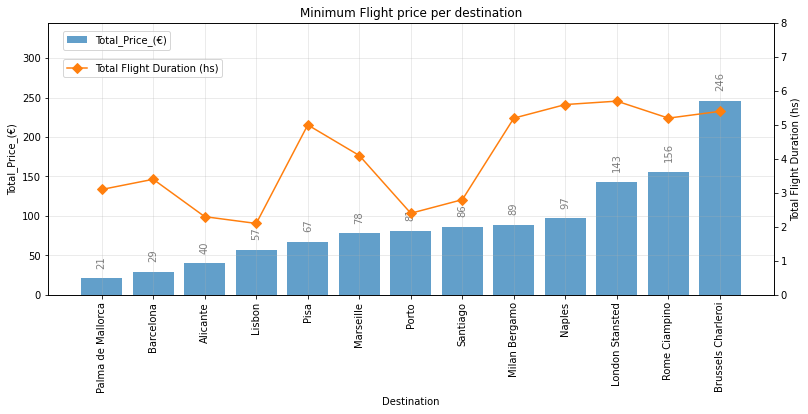

In [228]:
def bar_plot(data, num, cat,aux):
    fig = Figure(figsize=(13,5))
    FigureCanvas(fig)
    ax = fig.add_subplot()
    ax2 = ax.twinx()
    
    df = data.groupby(cat).min().sort_values(by = num)

    ax.bar(df.index, df[num], alpha = 0.7, label = df[num].name)
   
    ax.grid(alpha = 0.3)
    ax.legend(loc=(0.02,0.9))
    
    if ax.get_yticks().max() > 1e3:
        ax.set_yticklabels([f"{round(int(x)/1000)}" for x in ax.get_yticks()])
        for i in range(len(df)):
            ax.annotate(str(round(df[num][i]/1000)), xy=(i,df[num][i]+(df[num].max()*.05)),
                        ha='center', va='bottom',rotation = 90,alpha=0.5)
        
        ax.set(xlabel = df.index.name,
           ylabel = f"{df[num].name} [k]",
           title = "Minimum Flight price per destination")
    else:
        for i in range(len(df)):
            ax.annotate(str(round(df[num][i])), xy=(i,df[num][i]+(df[num].max()*.05)), 
                        ha='center', va='bottom',rotation = 90,alpha=0.5)
        
        ax.set(xlabel = f"{df.index.name}",
           ylabel = df[num].name,
           title = "Minimum Flight price per destination")  
        
    ax.set_xticklabels(df.index, rotation=90)
    ax.set_ylim(0,df[num].max()*1.4)
    
#     aux.plot(ax=ax2,kind="line",color="orange",grid=True,label = "Flights Total Duration")
    ax2.plot(df[aux], color="C1", marker="D", ms=7, label = "Total Flight Duration (hs)")
    ax2.set_ylim(0,8)
    ax2.set(ylabel = "Total Flight Duration (hs)")
    ax2.legend(loc=(0.02,0.8))
    
    plt.show()
    return fig

bar_plot(flights_df2, "Total_Price_(€)", "Destination","Total_Durac_(hs)")

## Export to csv files

In [ ]:
#### EXPORT ####

now = datetime.datetime.now()
now_string = now.strftime("%d-%m_%Hh%Mm")

# salida = pd.to_datetime(departure_date,format= '"%Y-%m-%d"').strftime("%d")
# llegada = pd.to_datetime(back_date,format= '"%Y-%m-%d"').strftime("%d")

# flights_df_dep.to_csv(f"RESULTS\\1_{now_string}_{start}_{salida}_{llegada}.csv",encoding='utf-8')
# flights_df_arrive.to_csv(f"RESULTS\\2_{now_string}_{start}_{salida}_{llegada}.csv",encoding='utf-8')
# flights_df2.to_csv(f"RESULTS\\3_{now_string}_{start}_{salida}_{llegada}.csv",encoding='utf-8')

flights_df_dep.to_csv(f"RESULTS\\1_{now_string}_{start}.csv",encoding='utf-8')
flights_df_arrive.to_csv(f"RESULTS\\2_{now_string}_{start}.csv",encoding='utf-8')
flights_df2.to_csv(f"RESULTS\\3_{now_string}_{start}.csv",encoding='utf-8')